# preprocessing

In [115]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 491 (delta 36), reused 33 (delta 11), pack-reused 387 (from 2)
Receiving objects: 100% (491/491), 36.65 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Updating files: 100% (19/19), done.


In [116]:
import pandas as pd
transactions = pd.read_csv('/content/TabularDS/final_project/data/movies_with_clusters.csv')
# min_support = 12 / len(transactions)
min_support = 0.35
transactions = transactions[0:20000]

#Apriori for rule mining

In [117]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

# transactions = data.groupby('CustomerID')['Description'].apply(list).tolist()
# print(f"number of transactions is: {len(transactions)}")

In [118]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Baseline apriori results

In [ ]:
if rules:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:10])

In [120]:
import numpy as np

# Calculate the average support, confidence, and lift from the rules DataFrame
avg_support = np.mean(rules['support'])
avg_confidence = np.mean(rules['confidence'])
avg_lift = np.mean(rules['lift'])

# Print the metrics
print(f"\nMetrics: Support average: {avg_support:.4f}, Confidence average: {avg_confidence:.4f}, Lift average: {avg_lift:.4f}")

# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.3542, Confidence average: 0.7334, Lift average: 1.5166


## Visualize top rules
### (sorted by lift)

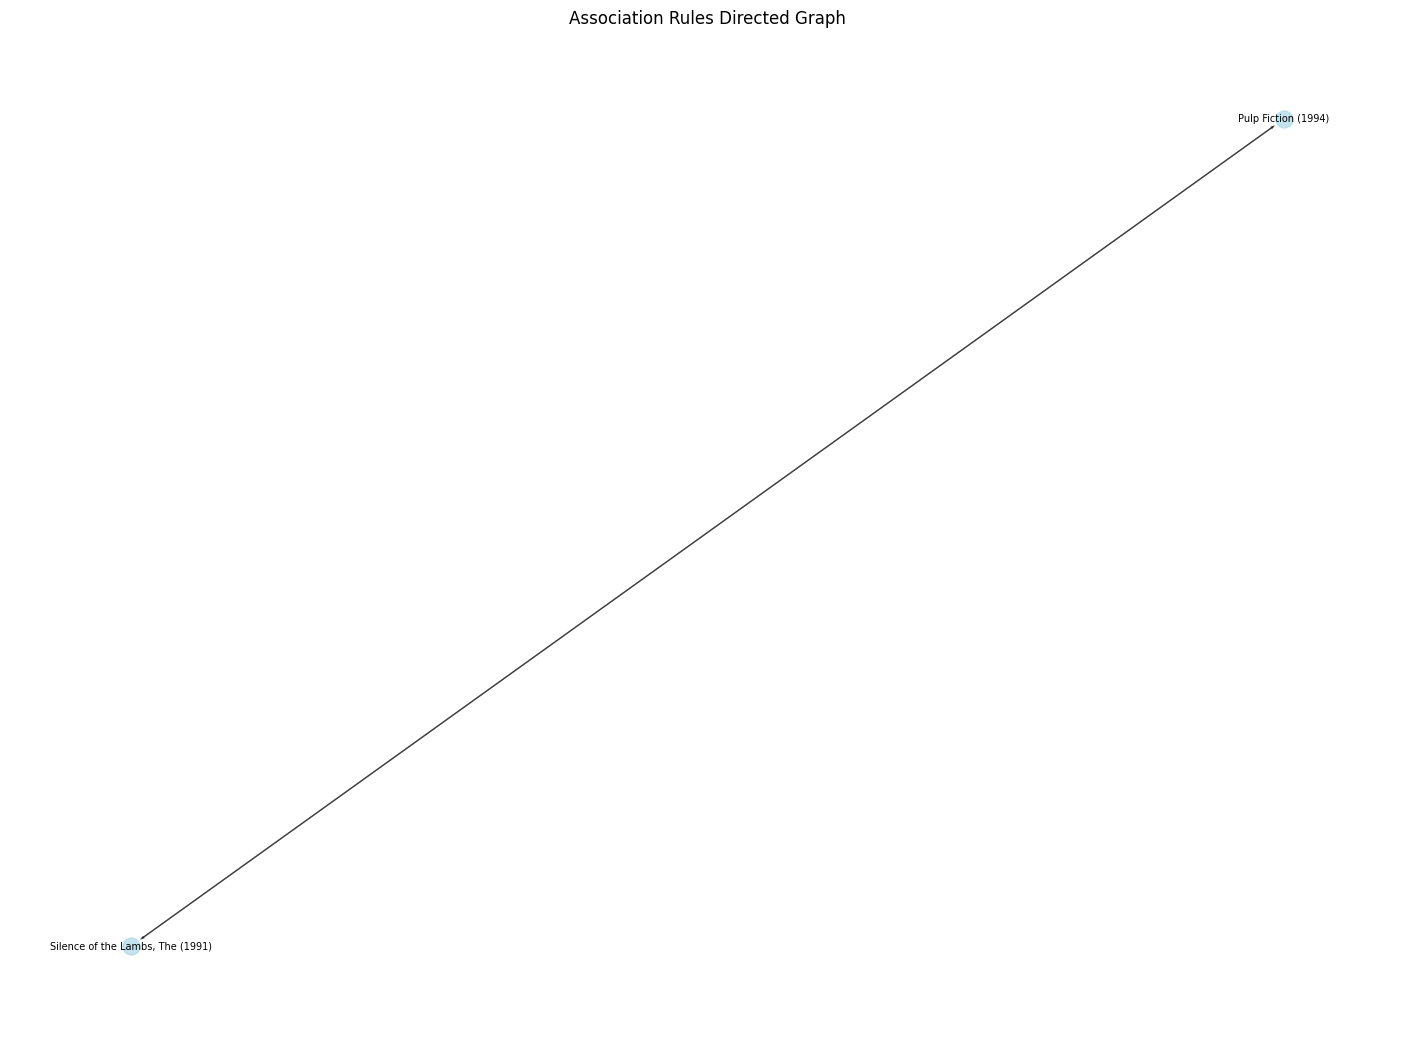

In [121]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
def plot_topk_rules_in_graph(rules, frequent_itemsets, k=10):

    # Create a directed graph
    G = nx.DiGraph()
    narrow_rules = rules.sort_values(by='lift', ascending=False).head(k)
    # Add nodes and directed edges
    for _, rule in narrow_rules.iterrows():
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))

        # Add a directed edge from antecedent to consequent
        G.add_edge(antecedent, consequent)

    # Draw the directed graph
    plt.figure(figsize=(18, 13))
    pos = nx.spring_layout(G, k=0.5, iterations=k)  # Layout for the graph

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=150, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=3)
    nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

    # Add edge labels (optional, if you want to display lift, confidence, or support)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Association Rules Directed Graph")
    plt.axis('off')
    plt.show()

plot_topk_rules_in_graph(rules, frequent_itemsets)

max lift value is 1.5166
max confidence value is 0.7584


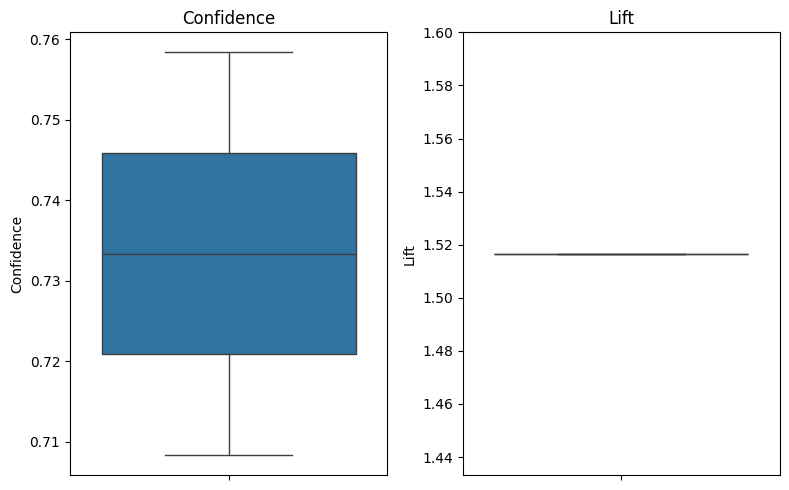

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_boxplots(rules):
  if not rules.empty:


      print(f"max lift value is {rules['lift'].max():.4f}")
      print(f"max confidence value is {rules['confidence'].max():.4f}")

      fig, axes = plt.subplots(1, 2, figsize=(8, 5))

      # plot Confidence
      sns.boxplot(data=rules['confidence'], ax=axes[0])
      axes[0].set_title('Confidence')
      axes[0].set_ylabel('Confidence')

      # plot Lift
      sns.boxplot(data=rules['lift'], ax=axes[1])
      axes[1].set_title('Lift')
      axes[1].set_ylabel('Lift')

      # show plot
      plt.tight_layout()
      plt.show()
  else:
      print("No rules to plot.")



plot_metrics_boxplots(rules)


# Cluster items + Apriori


In [123]:
from sklearn.cluster import KMeans


def add_cluster_users_col(num_clusters, transactions_matrix):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    user_clusters = kmeans.fit_predict(transactions_matrix)
    transactions_matrix['Cluster'] = user_clusters


num_clusters = 50
add_cluster_users_col(num_clusters,transactions)
df = transactions

<ipython-input-124-97f26412de46>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


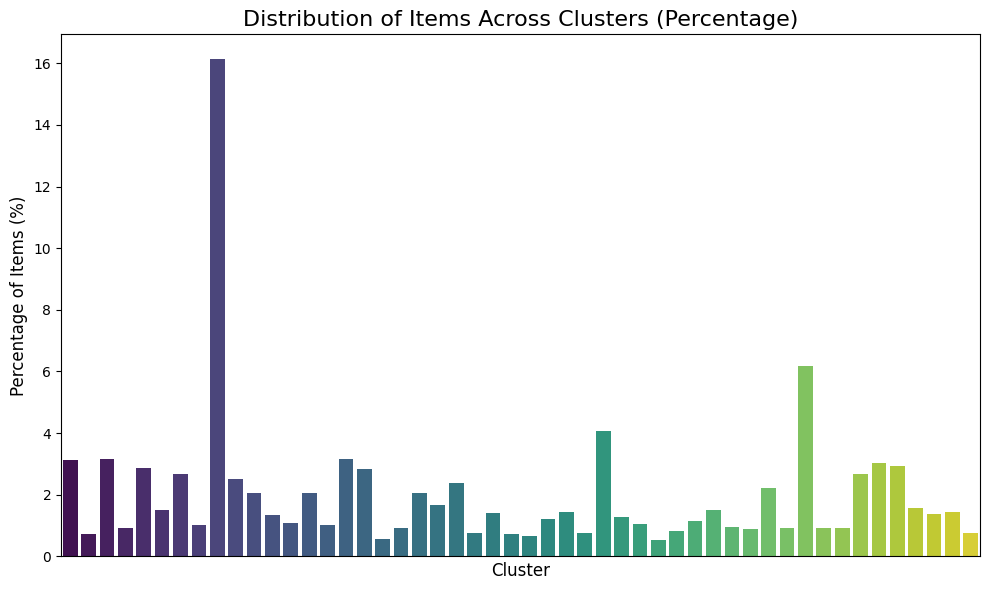

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the distribution of clusters (as percentages only)
cluster_percentages = (df['Cluster'].value_counts(normalize=True) * 100).sort_index()

# Plot the distribution using seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Items Across Clusters (Percentage)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage of Items (%)', fontsize=12)

# Remove x-tick labels (to avoid showing the cluster index)
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'], metric='hamming')
print(f"silhouette score of clustering is: {score}")


In [ ]:

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide*")
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*DataFrames with non-bool types result in worse computationalperformance*")

from mlxtend.frequent_patterns import fpgrowth, association_rules
import numpy as np

# Function to compute global support
import numpy as np

def calculate_global_support(itemset, full_data):
    """Calculate global support of an itemset across the entire transactions dataset efficiently."""
    itemset = list(itemset)  # Ensure itemset is a list
    relevant_rows = full_data[itemset].sum(axis=1) == len(itemset)  # Check if all items are present
    return relevant_rows.mean()  # Equivalent to sum(relevant_rows) / len(full_data)


# Function to process a single cluster
def process_cluster(cluster_id, df, full_data, min_support):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions of the current cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])

    # Adjust min_support based on cluster size
    # scale_k = min_support * np.log(len(full_data))
    # min_support = scale_k / np.log(len(cluster_data)) if len(cluster_data) > 0 else 0
    # scale_k = min_support / np.log(len(full_data))
    # min_support = scale_k * np.log(len(cluster_data)) if len(cluster_data) > 0 else 0

    min_support = 0.35

    print(f"min_support: {min_support:.5f}")

    # Run FPGrowth
    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)
    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)



    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")

    # plot_topk_rules_in_graph(rules, frequent_itemsets, k=10)

    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}

def find_clusters_rules(df, min_support):
  # Process clusters sequentially (without parallel computation)
  cluster_results = {}
  # Loop through all unique cluster IDs
  for cluster_id in sorted(df['Cluster'].unique()):
      if df['Cluster'].value_counts()[cluster_id] < 30:
          cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
          continue
      cluster_results[cluster_id] = process_cluster(cluster_id, df, df, min_support)
  return cluster_results

# pass the min support determined for the **baseline** whole dataset rule generation approach (will be scaled to match the smaller clusters)
cluster_results = find_clusters_rules(transactions, 0.1)

In [ ]:
# Add diagnostic prints for a few rules
for index, row in rules.iloc[:10].iterrows():
    antecedent = set(row["antecedents"])
    consequent = set(row["consequents"])
    rule = antecedent.union(consequent)

    # Calculate and print the components
    ant_supp = calculate_global_support(antecedent, transactions)
    cons_supp = calculate_global_support(consequent, transactions)
    rule_supp = calculate_global_support(rule, transactions)

    confidence = rule_supp / ant_supp if ant_supp > 0 else 0
    lift = confidence / cons_supp if cons_supp > 0 else 0

    print(f"Rule: {antecedent} → {consequent}")
    print(f"Antecedent support: {ant_supp:.8f}")
    print(f"Consequent support: {cons_supp:.8f}")
    print(f"Rule support: {rule_supp:.8f}")
    print(f"Confidence: {confidence:.8f}")
    print(f"Lift: {lift:.2f}")
    print("-" * 50)

In [ ]:
# Compute global metrics for each rule


for _, cluster_data in cluster_results.items():
  if cluster_data is None:
    continue
  rules = cluster_data [1]["rules"]
  if rules is None:
    continue
  # Calculate global support for antecedents
  rules["global_antecedent_support"] = rules["antecedents"].apply(
      lambda x: calculate_global_support(set(x), transactions)
  )

  # Calculate global support for consequents
  rules["global_consequent_support"] = rules["consequents"].apply(
      lambda x: calculate_global_support(set(x), transactions)
  )

  # Calculate global support for antecedent + consequent together
  rules["global_rule_support"] = rules.apply(
      lambda row: calculate_global_support(
          set(row["antecedents"]).union(set(row["consequents"])),
          transactions
      ),
      axis=1
  )

  # Calculate global confidence
  rules["global_confidence"] = rules["global_rule_support"] / rules["global_antecedent_support"]

  # Calculate global lift
  rules["global_lift"] = rules["global_confidence"] / rules["global_consequent_support"]


In [ ]:
import matplotlib.pyplot as plt

# Initialize dictionary to store average metrics per cluster
cluster_metrics = {}

for cluster_id, data in cluster_results.items():
    # Access the dictionary that is the second element of the tuple
    rules = data[1]["rules"]

    if rules is not None and not rules.empty:
        avg_support = rules["global_rule_support"].mean()
        avg_confidence = rules["global_confidence"].mean()
        avg_lift = rules["global_lift"].mean()
    else:
        avg_support, avg_confidence, avg_lift = 0, 0, 0  # Handle empty clusters

    cluster_metrics[cluster_id] = {
        "Avg Support": avg_support,
        "Avg Confidence": avg_confidence,
        "Avg Lift": avg_lift
    }

# Convert dictionary to DataFrame for easier plotting
metrics_df = pd.DataFrame.from_dict(cluster_metrics, orient="index")
print(metrics_df)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to store data for plotting
cluster_metrics_list = []
overall_metrics = {
    'Lift': [],
    'Confidence': [],
    'Support': [],
    'All Clusters': [],
    'Original Rules': []
}

# Extract the metrics for each cluster
for cluster_id, data in cluster_results.items():
    rules = data[1]["rules"]
    if rules is not None and not rules.empty:
        avg_support = rules["global_rule_support"].mean()
        avg_confidence = rules["global_confidence"].mean()
        avg_lift = rules["global_lift"].mean()
    else:
        avg_support, avg_confidence, avg_lift = 0, 0, 0  # Handle empty clusters

    # Add metrics to the list for each cluster
    cluster_metrics_list.append({
        'Cluster': cluster_id,
        'Avg Support': avg_support,
        'Avg Confidence': avg_confidence,
        'Avg Lift': avg_lift
    })

# Calculate the metrics for all clusters combined
all_rules_df = pd.concat([data[1]["rules"] for cluster_id, data in cluster_results.items() if data[1]["rules"] is not None], ignore_index=True)

if not all_rules_df.empty:
    avg_support_all_clusters = all_rules_df["support"].mean()
    avg_confidence_all_clusters = all_rules_df["confidence"].mean()
    avg_lift_all_clusters = all_rules_df["lift"].mean()
else:
    avg_support_all_clusters = avg_confidence_all_clusters = avg_lift_all_clusters = 0

# Add all clusters combined metrics to overall metrics
overall_metrics['All Clusters'] = [avg_support_all_clusters, avg_confidence_all_clusters, avg_lift_all_clusters]

# Calculate the metrics for the original (baseline) rules
original_rules_df = original_rules  # Assuming you have the baseline rules in 'original_rules'
if not original_rules_df.empty:
    avg_support_original = original_rules_df["support"].mean()
    avg_confidence_original = original_rules_df["confidence"].mean()
    avg_lift_original = original_rules_df["lift"].mean()
else:
    avg_support_original = avg_confidence_original = avg_lift_original = 0

# Add original rules metrics to overall metrics
overall_metrics['Original Rules'] = [avg_support_original, avg_confidence_original, avg_lift_original]

# Convert cluster metrics list into a DataFrame for easier plotting
cluster_metrics_df = pd.DataFrame(cluster_metrics_list)

# Prepare the data for plotting each metric separately
metrics = ['Avg Support', 'Avg Confidence', 'Avg Lift']
overall_values = {
    'All Clusters': overall_metrics['All Clusters'],
    'Original Rules': overall_metrics['Original Rules']
}

# Create individual plots for each metric (Support, Confidence, Lift)
for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the metrics for each cluster
    sns.barplot(x='Cluster', y=metric, data=cluster_metrics_df, color='lightgreen', label=f'{metric} per Cluster', ax=ax)

    # Plot the overall metrics (all clusters and original rules)
    ax.axhline(y=overall_values['All Clusters'][metrics.index(metric)], color='blue', linestyle='--', label=f'{metric} (All Clusters)')
    ax.axhline(y=overall_values['Original Rules'][metrics.index(metric)], color='darkblue', linestyle=':', label=f'{metric} (Original Rules)')

    # Add labels and title
    ax.set_title(f'{metric} Comparison for Clusters and Baseline Rules', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(f'{metric} Value', fontsize=12)
    ax.legend(title='Metric Type')

    # Show the plot
    plt.tight_layout()
    plt.show()
